##Make X not baD!

Load X and Y from getting satellite channels 1 and 6 data, see satellite-to-sensor-model.ipynb for more info.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from data_helper_functions import *
from IPython.display import display
pd.options.display.max_columns = 999
%matplotlib inline

In [2]:
with np.load('data/X.npz') as data:
    X = data['X']

with np.load('data/Y.npz') as data:
    Y = data['Y']

In [3]:
print X.shape
print Y.shape

(2544, 2476)
(2544, 14)


Random Forest seems to be giving the best results, so we'll stick with that for now

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
rfr = RandomForestRegressor(oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 14)

In [5]:
rfr.fit(X_train,Y_train)

/home/ubuntu/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:659: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [6]:
rfr.score(X_test,Y_test)

0.030842791854099993

In [7]:
Y_pred = rfr.predict(X_test)
from random import randint
val = randint(0,508)
print Y_pred[val]
print Y_test[val]

[-1898.04073451 -1895.44739133 -1874.99465429 -1862.62083899 -1872.08635517
 -1888.94023789 -1878.36506936 -1899.1076668  -1898.16786753 -1898.20189851
 -1898.21882193 -1898.17638099 -1897.81655789 -1898.10105721]
[-1049.38756217 -1049.66777813 -1049.1949189  -1049.17124527 -1049.44469013
 -1049.60373762 -1049.56861818 -1046.84618117 -1045.290315   -1045.314015
 -1045.0869825  -1044.91115667 -1044.6794105  -1044.81481833]


Maybe I should only use the AOD values since the sensor values are sporadic and don't add as much to the data anyway.  Also, I could remove the rows were the sensor readings are zero.  I could look through the Y rows and make a mask to apply to both X and Y rows.

In [8]:
mask = []
for i,row in enumerate(Y):
    if row[0] == 0:
        mask.append(False)
    else:
        mask.append(True)    

In [9]:
mask = np.array(mask)

In [10]:
X_reduced = X[mask]
Y_reduced = Y[mask][:,-7::]

In [11]:
print X_reduced.shape
print Y_reduced.shape

(2302, 2476)
(2302, 7)


In [12]:
rfr = RandomForestRegressor(oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y_reduced, test_size = 0.3, random_state = 14)

In [197]:
rfr.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [198]:
print rfr.score(X_test,Y_test)
print rfr.oob_score_

0.0800125607355
-0.0936330642013


In [199]:
Y_pred = rfr.predict(X_test)

In [200]:
from random import randint
val = randint(0,Y_pred.shape[0])
print Y_pred[val]
print Y_test[val]

[-2962.90243532 -2962.88878597 -2962.89901777 -2962.90393853 -2962.9060391
 -2962.87717588 -2962.90578052]
[-3732.59078983 -3732.40831117 -3732.3851785  -3732.37497417 -3732.37765883
 -3732.33242967 -3732.37806767]


Let's try Ridge again.

In [17]:
from sklearn.linear_model import Ridge
ridge = Ridge(solver = 'auto')
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y_reduced, test_size = 0.5, random_state = 14)

In [18]:
ridge.fit(X_train,Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [19]:
ridge.score(X_test,Y_test)

-2.0626980586035355

In [20]:
Y_pred = ridge.predict(X_test)

In [196]:
from random import randint
val = randint(0,Y_pred.shape[0]-1)
print Y_pred[val]
print Y_test[val]

[-4278.18991    -4277.98500289 -4277.94563314 -4278.02877961 -4278.02623493
 -4277.81172583 -4278.03564841]
[-4432.7487905  -4432.65517167 -4432.671593   -4432.682409   -4432.68769133
 -4432.644714   -4432.68905467]


Not too good. Or at least not an improvement over itself even.

I may have to do some feature engineering for the images.  Averaging, filtering or both. I wonder if I do some ratios of channels?  Sort of like the "greenness" parameter that farmers use.  Also, maybe +/- 3 hours is too long for searching for a satellite image. (Reduce to +/- 1 hour?)

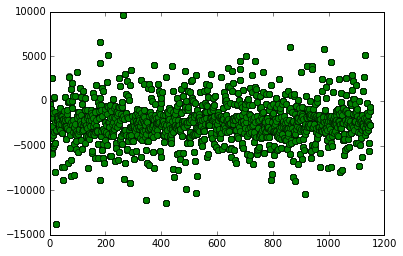

In [189]:
plt.plot(Y_pred,'go');

So, from the plot above, there are values above 0, even though my Y_train and Y_test are all below zero.

[  0.00000000e+00   0.00000000e+00   1.52129817e-06   4.96957404e-05
   2.63691684e-04   1.67342799e-04   1.44523327e-04   7.50507099e-05
   6.79513185e-05   5.37525355e-05   5.67951318e-05   4.15821501e-05
   3.19472617e-05   1.77484787e-05   1.67342799e-05   6.59229209e-06
   3.54969574e-06   1.52129817e-06   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.98807157e-06   4.37375746e-05
   1.13320080e-04   1.07355865e-04   1.09343936e-04   1.07355865e-04
   9.14512922e-05   1.01391650e-04   4.17495030e-05   9.54274354e-05
   9.54274354e-05   9.14512922e-05   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


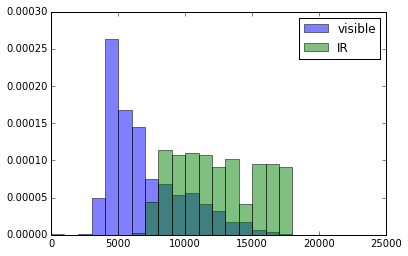

In [260]:
val = randint(0,2301)
_ = plt.hist(X_reduced[:,0:1972][val], alpha = 0.5, normed=True, bins=25, label='visible',range=(0,25000)) #visible light histogram
_ = plt.hist(X_reduced[:,1973:2476][val], alpha = 0.5, normed=True, bins=25, label='IR',range=(0,25000))
plt.legend(loc='upper right');
hist1, bin_edges1 = np.histogram(X_reduced[:,0:1972][val], density=True, bins=25, range=(0,25000))
hist2, bin_edges2 = np.histogram(X_reduced[:,1973:2476][val], density=True, bins=25, range=(0,25000))

array([  0.00000000e+00,   0.00000000e+00,   4.00608519e-05,
         2.29208925e-04,   2.08417850e-04,   1.50101420e-04,
         7.04868154e-05,   5.07099391e-05,   3.60040568e-05,
         4.25963489e-05,   3.19472617e-05,   2.43407708e-05,
         2.28194726e-05,   1.47058824e-05,   1.57200811e-05,
         1.82555781e-05,   1.82555781e-05,   1.62271805e-05,
         6.08519270e-06,   2.53549696e-06,   1.01419878e-06,
         5.07099391e-07,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

In [263]:
np.hstack((hist1,hist2)).shape

(50,)